In [1]:
import numpy as np
import torch 

import pennylane as qml
from pennylane.operation import Operation, AnyWires

#dev0 = qml.device("default.qubit",wires=3)

class RBSGate(Operation):
    num_wires = 2  

    def __init__(self, theta, wires, id=None):
        all_wires = qml.wires.Wires(wires)
        super().__init__(theta, wires=all_wires, id=id)

    @staticmethod
    def compute_decomposition(theta, wires):
        decomp = [
                qml.Hadamard(wires=wires[0]),
                qml.Hadamard(wires=wires[1]),
                qml.CZ(wires=wires),
                qml.RY(theta/2.,wires=wires[0]),
                qml.RY(-theta/2.,wires=wires[1]),
                qml.CZ(wires=wires),
                qml.Hadamard(wires=wires[0]),
                qml.Hadamard(wires=wires[1])
            ]
        return decomp

In [2]:
s=0.02
init_method=lambda x: torch.nn.init.uniform_(x,a=0.,b=s*np.pi)

#n_qubits = 3
#dev = qml.device("default.qubit", wires=n_qubits)
#
#@qml.qnode(dev)
#def probs_single(inputs, weights):
#    shape=[3,1]
#    
#    qml.PauliX(wires=0)
#    # make the input vector norm1
#    
#    # load input
#    prd_fact=1.0
#    for qi in range(0,shape[0]-1):
#        theta_i=torch.arccos(torch.sqrt(inputs[...,qi])/prd_fact)
#        prd_fact=prd_fact*torch.sin(theta_i)
##        print(f"qubit: {qi}, input: {inputs[...,qi]}, fact_new: {prd_fact}, theta_i: {theta_i}")
##        input()
#        RBSGate(theta_i,wires=[qi,qi+1],id=f"$\\alpha_{qi}$")
#    
#    # parametric circuit
#    ctr=0
#    for j in range(shape[1]):
#        for i in range(0,shape[0]-j-1):
#            RBSGate(weights[0][ctr],[i,i+1],id=f"$\\theta_{ctr}$")
#            ctr+=1
#    return qml.probs(wires=range(shape[0]-shape[1],shape[0]))

#n_layers = 1
#n_pars = 2
#weight_shapes = {"weights": (n_layers, n_pars)}
#qlayer = qml.qnn.TorchLayer(probs_single, weight_shapes)
##qml.draw(probs_single)([0,1],[0.1,0.2])

n_qubits1=5
n_layers1 = 1
n_pars1 = 3+3+2+1
dev1 = qml.device("default.qubit", wires=n_qubits1)
@qml.qnode(dev1)
def probs_single1(inputs, weights):
    shape=[3,5]
    max_q=np.max(shape)
    
    q_base=max_q-shape[0]
    qml.PauliX(wires=q_base)
    
    # load input
    prd_fact=1.0
    for qi_idx, qi in enumerate(range(max_q-shape[0],max_q-1)):
        #print(inputs,qi,inputs[...,qi_idx])
        theta_i=torch.arccos(torch.sqrt(inputs[...,qi_idx])/prd_fact)
        prd_fact=prd_fact*torch.sin(theta_i)
#        print(f"qubit: {qi}, input: {inputs[...,qi]}, fact_new: {prd_fact}, theta_i: {theta_i}")
#        input()
        RBSGate(theta_i,wires=[qi,qi+1],id=f"$\\alpha1_{{{{{qi}}}}}$")
    
    # parametric circuit
    ctr=0
#    for j in range(max_q,0,-1):
#        if shape[1]-j>=0:
#            for i in range(shape[1]-j,shape[1]-j+shape[0]-1):
#                
    for ji,j in enumerate(range(max_q,max_q-shape[1],-1)):
        for i in range(q_base-1-ji,q_base-1-ji+shape[0]):
            if i<0:
                continue
            RBSGate(weights[0][ctr],[i,i+1],id=f"$\\theta1_{{{{{ctr}}}}}$")
            ctr+=1
    return qml.probs(wires=range(max_q-shape[1],max_q))

weight_shapes1 = {"weights": (n_layers1, n_pars1)}
qlayer1 = qml.qnn.TorchLayer(probs_single1, weight_shapes1,init_method=init_method)

n_qubits2=5
n_layers2 = 1
n_pars2 = 4+3
dev2 = qml.device("default.qubit", wires=n_qubits2)
@qml.qnode(dev2)
def probs_single2(inputs, weights): # inverted pyramid
    shape=[5,2]
    max_q=np.max(shape)
    
    q_base=max_q-shape[0]
    qml.PauliX(wires=q_base)
    
    # load input
    prd_fact=1.0
    for qi_idx, qi in enumerate(range(max_q-shape[0],max_q-1)):
        theta_i=torch.arccos(torch.sqrt(inputs[...,qi_idx])/prd_fact)
        prd_fact=prd_fact*torch.sin(theta_i)
#        print(f"qubit: {qi}, input: {inputs[...,qi]}, fact_new: {prd_fact}, theta_i: {theta_i}")
#        input()
        RBSGate(theta_i,wires=[qi,qi+1],id=f"$\\alpha2_{{{{{qi}}}}}$")
    
    # parametric circuit
    ctr=0
    for j in range(max_q,max_q-shape[1],-1):
        for i in range(0,j-1):
            RBSGate(weights[0][ctr],[i,i+1],id=f"$\\theta2_{{{{{ctr}}}}}$")
            ctr+=1
    probs=qml.probs(wires=range(max_q-shape[1],max_q))
    return probs

weight_shapes2 = {"weights": (n_layers2, n_pars2)}
qlayer2 = qml.qnn.TorchLayer(probs_single2, weight_shapes2,init_method=init_method)

(<Figure size 792x432 with 1 Axes>, <Axes:>)

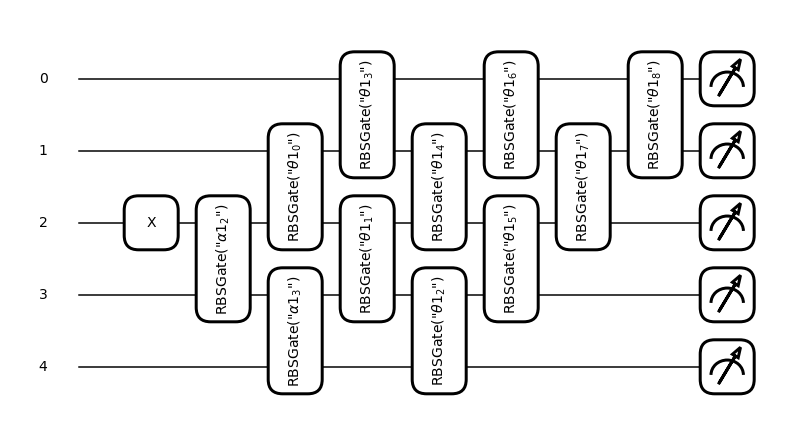

In [3]:
qml.draw_mpl(probs_single1)(torch.tensor([list(range(3)),]),torch.tensor([list(range(n_pars1)),]))

(<Figure size 792x432 with 1 Axes>, <Axes:>)

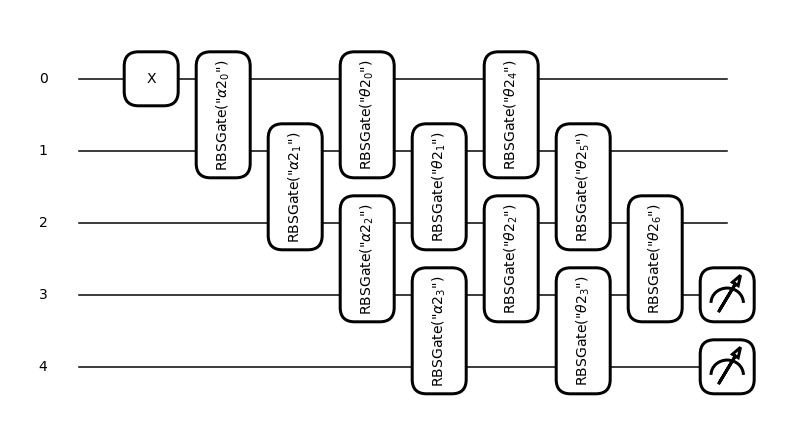

In [4]:
qml.draw_mpl(probs_single2)(torch.tensor([list(range(5)),]),torch.tensor([list(range(n_pars2)),]))

In [5]:
import torch.nn as nn
class ProbsToUnaryLayer(nn.Module):

    def __init__(self, size_in):
        super(ProbsToUnaryLayer, self).__init__()
        self.size_q_in=size_in

    def forward(self, input_var):
        filt = [2**i for i in range(self.size_q_in)]
        return input_var[:, filt]

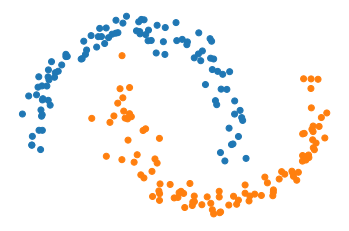

Average loss over epoch 1: 0.6932
Average loss over epoch 2: 0.6931
Average loss over epoch 3: 0.6931
Average loss over epoch 4: 0.6931
Average loss over epoch 5: 0.6931
Average loss over epoch 6: 0.6931
Average loss over epoch 7: 0.6930
Average loss over epoch 8: 0.6931
Average loss over epoch 9: 0.6930
Average loss over epoch 10: 0.6932
Average loss over epoch 11: 0.6933
Average loss over epoch 12: 0.6931
Average loss over epoch 13: 0.6937
Average loss over epoch 14: 0.6932
Average loss over epoch 15: 0.6932
Average loss over epoch 16: 0.6932
Average loss over epoch 17: 0.6932
Average loss over epoch 18: 0.6932
Average loss over epoch 19: 0.6931
Average loss over epoch 20: 0.6931
Accuracy: 50.0%


In [7]:
import matplotlib.pyplot as plt
import pennylane.numpy as np
import numpy as np

from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

X, y_ = make_moons(n_samples=200, noise=0.1)

X_mean, X_std=np.mean(X,axis=0), np.std(X,axis=0,ddof=1)

X=(X-X_mean)/X_std

X=np.hstack((X,2.0*np.ones(X.shape[0])[:,None]))
X=np.array([np.clip(row/np.sqrt(np.sum(row**2)),-1,1) for row in X])

#y_ = torch.unsqueeze(torch.tensor(y_,requires_grad=False), 1)  # used for one-hot encoded labels
#y_hot = torch.scatter(torch.zeros((200, 2),requires_grad=False), 1, y_, 1)

c = ["#1f77b4" if iy_ == 0 else "#ff7f0e" for iy_ in y_]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

# @qml.qnode(dev)
# def qnode(inputs, weights):
#     qml.AngleEmbedding(inputs, wires=range(n_qubits))
#     qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
#     return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# n_layers = 6
#weight_shapes = {"weights": (n_layers, n_qubits)}
#§qlayer = qml.qnn.TorchLayer(qlayer, weight_shapes)
clayer_1 = torch.nn.Linear(3, 3)
#clayer_1.weight.requires_grad=False
#clayer_1.bias.requires_grad=False
#clayer_2 = torch.nn.Linear(2, 2)
#clayer_2.weight.requires_grad=False
#clayer_2.bias.requires_grad=False
softmax_1 = torch.nn.Softmax(dim=1)
probs_to_unary_lay1=ProbsToUnaryLayer(5)
clayer_2 = torch.nn.Linear(5, 5)

softmax_2 = torch.nn.Softmax(dim=1)
probs_to_unary_lay2=ProbsToUnaryLayer(2)
clayer_3 = torch.nn.Linear(2, 2)
softmax_3 = torch.nn.Softmax(dim=1)

#layers = [clayer_1,softmax_1,qlayer1,probs_to_unary_lay1,clayer_2,softmax_2,qlayer2,probs_to_unary_lay2,softmax_3]
layers = [softmax_1,qlayer1,probs_to_unary_lay1,softmax_2,qlayer2,probs_to_unary_lay2,softmax_3]
#layers = [clayer_1,softmax_2,qlayer2,probs_to_unary_lay2,softmax_3]
model = torch.nn.Sequential(*layers)
#print(model)

#print([pm for pm in model.parameters()])

#opt = torch.optim.SGD(model.parameters(), lr=0.2)
opt = torch.optim.Adam(model.parameters(), lr=0.1)
#loss = torch.nn.L1Loss()
loss = torch.nn.CrossEntropyLoss()

X = torch.tensor(X, requires_grad=False).float()
y = torch.tensor(y_, requires_grad=False).long()
#y_hot = y_hot.float()

batch_size = 8
batches = 200 // batch_size

#print(X)
data_loader = torch.utils.data.DataLoader(
    list(zip(X, y)), batch_size=batch_size, shuffle=True, drop_last=True
)

epochs = 20

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

#        print(xs)
#        print(xs, model(xs))
        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")